In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io as sio

from scipy.io import loadmat, savemat

In [ ]:
# Read the Excel file
file_name = 'Data_4_Import_REST.xlsx'  # Replace with your file path
excel_sheet_name = 'Depression Rest'
file_path = os.path.join("Depression_Study", "depression_data", file_name)
df_raw = pd.read_excel(file_path, sheet_name=excel_sheet_name)

# Extract values from the first column into two arrays
healthy_sample = df_raw[merged_merged_df_raw.iloc[:, 1] == 99].iloc[:, 0].tolist()
depressed_sample = df_raw[df_raw.iloc[:, 1] != 99].iloc[:, 0].tolist()

# Print the results
print("Healthy sample:", healthy_sample)
print("Depressed sample:", depressed_sample)

# Extract AAL source names
cser_values = loadmat("cser_values.mat")
source_names = [(cser_values['source_names'][i][0][0]) for i in range(60)]
print("Source names: ", source_names)

Healthy sample: [507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 560, 562, 563, 564, 566, 568, 569, 570, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 588, 589, 590, 593, 596, 599, 600, 601, 603, 609, 611, 612, 615, 617, 619, 620, 621, 623]
Depressed sample: [558, 559, 561, 565, 567, 571, 572, 586, 587, 591, 592, 594, 595, 597, 598, 602, 604, 605, 606, 607, 608, 610, 613, 614, 616, 618, 622, 624, 625, 626, 627, 628]
Source names:  ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Roland

In [5]:
filename = 'eeg_source.mat'
eeg_source = h5py.File(filename, 'r')
eeg_source_open = eeg_source['eeg_source_open']
eeg_source_closed = eeg_source['eeg_source_closed']

def get_eeg_list(eeg_source, sample_list):
    eeg_keys = eeg_source.keys()
    return [eeg_source[f'x{sample}'] for sample in sample_list if f'x{sample}' in eeg_keys]

eeg_source_open_healthy = get_eeg_list(eeg_source_open, healthy_sample)
eeg_source_open_depressed = get_eeg_list(eeg_source_open, depressed_sample)
eeg_source_closed_healthy = get_eeg_list(eeg_source_closed, healthy_sample)
eeg_source_closed_depressed = get_eeg_list(eeg_source_closed, depressed_sample)

In [5]:
def lzc_prep(eeg_source):
    all_subjects = []

    for i, subj_data in enumerate(eeg_source):
        if i % 10 == 0:
            print(f"Processing {i+1}/{len(eeg_source)}")
        subj_data = np.array(subj_data)  # shape: (samples, sources, trials)
        subj_srcs = []

        for src in range(60):
            # Reshape: concatenate across trials for the current source
            data_1d = subj_data[:, src, :].reshape(-1)
            
            # Binarize by median thresholding
            threshold = np.median(data_1d)
            binary_seq = (data_1d > threshold).astype(int)

            # Split into 4s epochs (sr = 500Hz)
            segment_length = 4 * 500
            n_segments = len(binary_seq) // segment_length
            subj_segments = [binary_seq[i*segment_length:(i+1)*segment_length] for i in range(n_segments)]

            subj_srcs.append(subj_segments)

        all_subjects.append(subj_srcs)

    print()
    return all_subjects


prep_open_healthy = lzc_prep(eeg_source_open_healthy)
prep_open_depressed = lzc_prep(eeg_source_open_depressed)   
prep_closed_healthy = lzc_prep(eeg_source_closed_healthy)   
prep_closed_depressed = lzc_prep(eeg_source_closed_depressed)   

Processing 1/89
Processing 11/89
Processing 21/89
Processing 31/89
Processing 41/89
Processing 51/89
Processing 61/89
Processing 71/89
Processing 81/89

Processing 1/30
Processing 11/30
Processing 21/30

Processing 1/89
Processing 11/89
Processing 21/89
Processing 31/89
Processing 41/89
Processing 51/89
Processing 61/89
Processing 71/89
Processing 81/89

Processing 1/30
Processing 11/30
Processing 21/30



In [ ]:
# Took 588 minutes = 9.8 hours

from lz76.lz76 import LZ76

# def calc_er(X):
#     lz = LZ76(X) # Compute Lempel-Ziv complexity
#     er = lz*np.log2(len(X))/len(X) # Normalize using log2(length)
#     return er

def compute_lz76(prep_data):
    """
    Computes LZ76 complexity for each segment in prep_data.
    Returns:
        lz76_per_subject_source: list of lists (subject, source mean)
        lz76_per_subject: list (subject mean)
        lz76_overall: float (overall mean)
    """
    lz76_per_subject_source = []
    lz76_per_subject = []

    for i, subj in enumerate(prep_data):
        subj_sources = []

        for j, src in enumerate(subj):
            if j % 10 == 0:
                print(f"Processing {i+1}/{len(prep_data)} subject's {j+1}/{len(subj)} source")
            # Calculating LZC per subject/source/segment
            src_seg_lz = [LZ76(seg) for seg in src if len(seg) > 0]
            # Calculating LZC per subject/source
            subj_sources.append(np.nanmean(src_seg_lz))
        
        lz76_per_subject_source.append(subj_sources)
        # Calculating LZC per subject
        lz76_per_subject.append(np.nanmean(subj_sources))

    # Calculating LZC overall
    lz76_overall = np.nanmean(lz76_per_subject)
    print()

    return lz76_per_subject_source, lz76_per_subject, lz76_overall


lz76_open_healthy = compute_lz76(prep_open_healthy)
lz76_open_depressed = compute_lz76(prep_open_depressed)
lz76_closed_healthy = compute_lz76(prep_closed_healthy)
lz76_closed_depressed = compute_lz76(prep_closed_depressed)

Processing 1/89 subject's 10/60 source
Processing 1/89 subject's 20/60 source
Processing 1/89 subject's 30/60 source
Processing 1/89 subject's 40/60 source
Processing 1/89 subject's 50/60 source
Processing 1/89 subject's 60/60 source
Processing 2/89 subject's 10/60 source
Processing 2/89 subject's 20/60 source
Processing 2/89 subject's 30/60 source
Processing 2/89 subject's 40/60 source
Processing 2/89 subject's 50/60 source
Processing 2/89 subject's 60/60 source
Processing 3/89 subject's 10/60 source
Processing 3/89 subject's 20/60 source
Processing 3/89 subject's 30/60 source
Processing 3/89 subject's 40/60 source
Processing 3/89 subject's 50/60 source
Processing 3/89 subject's 60/60 source
Processing 4/89 subject's 10/60 source
Processing 4/89 subject's 20/60 source
Processing 4/89 subject's 30/60 source
Processing 4/89 subject's 40/60 source
Processing 4/89 subject's 50/60 source
Processing 4/89 subject's 60/60 source
Processing 5/89 subject's 10/60 source
Processing 5/89 subject's

In [12]:
import pickle

# Save the four LZ76 results to a file for later retrieval
lz76_results = {
    'lz76_open_healthy': lz76_open_healthy,
    'lz76_open_depressed': lz76_open_depressed,
    'lz76_closed_healthy': lz76_closed_healthy,
    'lz76_closed_depressed': lz76_closed_depressed
}

with open('lz76_results.pkl', 'wb') as f:
    pickle.dump(lz76_results, f)

print("LZ76 results saved to lz76_results.pkl")

LZ76 results saved to lz76_results.pkl


In [8]:
import pickle

# Load the results from the file
lz76_results = None
with open('lz76_results.pkl', 'rb') as f:
    lz76_results = pickle.load(f)

# Unpack the results
lz76_open_healthy = lz76_results['lz76_open_healthy']
lz76_open_depressed = lz76_results['lz76_open_depressed']
lz76_closed_healthy = lz76_results['lz76_closed_healthy']
lz76_closed_depressed = lz76_results['lz76_closed_depressed']

In [9]:
# Average LZC for each source across subjects for each condition
def average_lz76_per_source(lz76_tuple):
    # lz76_tuple[0] is a list of lists: [subject][source]
    lz76_per_subject_source = lz76_tuple[0]
    # Transpose to [source][subject]
    lz76_per_source = np.array(lz76_per_subject_source).T
    # Average across subjects for each source
    return np.nanmean(lz76_per_source, axis=1)

lz76_open_healthy_source_avg = average_lz76_per_source(lz76_open_healthy)
lz76_open_depressed_source_avg = average_lz76_per_source(lz76_open_depressed)
lz76_closed_healthy_source_avg = average_lz76_per_source(lz76_closed_healthy)
lz76_closed_depressed_source_avg = average_lz76_per_source(lz76_closed_depressed)

In [10]:
# a dictionary for each of four calculations

# lz76_open_healthy
# lz76_open_depressed
# lz76_closed_healthy
# lz76_closed_depressed

# lz76_per_subject_source, lz76_per_subject, lz76_overall
# lz76_open_healthy_source_avg

# lzc_open_healthy
# lzc_open_healthy_subject
# lzc_open_healthy_subject_source
# lzc_open_healthy_source

lzc = {
    'open': {'healthy': {}, 'depressed': {}},
    'closed': {'healthy': {}, 'depressed': {}}
}

def structure_lzc(lzc_calcs, lzc_calcs_source, eyes, health):
    lzc[eyes][health]['avg'] = lzc_calcs[2]
    lzc[eyes][health]['subject_avg'] = lzc_calcs[1]
    lzc[eyes][health]['source_avg'] = lzc_calcs_source
    lzc[eyes][health]['subject_source'] = lzc_calcs[0]

structure_lzc(lz76_open_healthy, lz76_open_healthy_source_avg, 'open', 'healthy')
structure_lzc(lz76_open_depressed, lz76_open_depressed_source_avg, 'open', 'depressed')
structure_lzc(lz76_closed_healthy, lz76_closed_healthy_source_avg, 'closed', 'healthy')
structure_lzc(lz76_closed_depressed, lz76_closed_depressed_source_avg, 'closed', 'depressed')

print(lzc)

{'open': {'healthy': {'avg': 145.09764680471676, 'subject_avg': [163.9633333333333, 133.4233918128655, 141.76815476190475, 152.654, 149.5284090909091, 140.5029411764706, 132.95531914893616, 139.66394557823125, 147.54787234042553, 153.2560606060606, 136.80119047619047, 148.5748484848485, 148.53050314465406, 154.9281818181818, 155.47326388888894, 155.20131578947368, 153.05424242424243, 135.5787037037037, 130.4877358490566, 146.90999999999997, 155.08459119496854, 149.74839743589746, 159.61633986928103, 130.7375968992248, 137.94151515151515, 121.81695906432749, 124.15777777777778, 130.2848765432099, 127.18765432098765, 125.24276729559749, 139.5361111111111, 162.56818181818184, 150.6737373737374, 140.9485815602837, 136.65726495726497, 155.32765151515153, 133.77366666666668, 156.15929487179486, 146.85185185185185, 153.12160493827162, 138.95797101449276, 141.48303030303035, 157.2854609929078, 147.7612179487179, 137.7542553191489, 144.45987654320984, 138.01309523809522, 120.90890804597703, 155

In [11]:
region_map = {
    'frontal': [f'src{i+1:02d}_{source_names[i]}' for i in range(2, 16)] + [f'src{i:02d}_{source_names[i]}' for i in range(18, 24)],
    'occipital': [f'src{i+1:02d}_{source_names[i]}' for i in range(24, 36)],
    'parietal': [f'src{i+1:02d}_{source_names[i]}' for i in range(38, 50)],
    'sensorimotor': [f'src{i+1:02d}_{source_names[i]}' for i in [0, 1, 16, 17, 36, 37]],
    'temporal': [f'src{i+1:02d}_{source_names[i]}' for i in range(50, 60)]
}

def map_region(area):
    for region, sources in region_map.items():
        if area in sources:
            return region
    return area

In [12]:
# 1. lzc overall per list (average across eyes and health)
lzc_overall_records = []
for eyes in lzc:
    for health in lzc[eyes]:
        lzc_overall_records.append({
            'eyes': eyes,
            'health': health,
            'lz76_overall': lzc[eyes][health]['avg']
        })
lzc_overall_df = pd.DataFrame(lzc_overall_records)

# 2. lzc per subject (average across sources)
lzc_subject_records = []
for eyes in lzc:
    for health in lzc[eyes]:
        subj_avg = lzc[eyes][health]['subject_avg']
        subj_ids = healthy_sample if health == 'healthy' else depressed_sample
        for subj_idx, val in enumerate(subj_avg):
            lzc_subject_records.append({
                'eyes': eyes,
                'health': health,
                'subject_idx': subj_ids[subj_idx],
                'lz76_subject_avg': val
            })
lzc_subject_df = pd.DataFrame(lzc_subject_records)

# 3. lzc per source (average across subjects)
lzc_source_records = []
for eyes in lzc:
    for health in lzc[eyes]:
        source_avg = lzc[eyes][health]['source_avg']
        for src_idx, val in enumerate(source_avg):
            lzc_source_records.append({
                'eyes': eyes,
                'health': health,
                'source_idx': f'src{src_idx+1:02d}_{source_names[src_idx]}',
                'lz76_source_avg': val
            })
lzc_source_df = pd.DataFrame(lzc_source_records)

# 4. lzc per subject per source (one row per subject per source per condition)
lzc_subject_source_records = []
for eyes in lzc:
    for health in lzc[eyes]:
        subj_src = lzc[eyes][health]['subject_source']
        subj_ids = healthy_sample if health == 'healthy' else depressed_sample
        for subj_idx, src_list in enumerate(subj_src):
            for src_idx, val in enumerate(src_list):
                lzc_subject_source_records.append({
                    'eyes': eyes,
                    'health': health,
                    'subject_idx': subj_ids[subj_idx],
                    'source_idx': f'src{src_idx+1:02d}_{source_names[src_idx]}',
                    'lz76_subject_source': val
                })
lzc_subject_source_df = pd.DataFrame(lzc_subject_source_records)

# 5. lzc per subject per brain region
lzc_subject_region_records = []
for eyes in lzc:
    for health in lzc[eyes]:
        subj_src = lzc[eyes][health]['subject_source']
        subj_ids = healthy_sample if health == 'healthy' else depressed_sample
        for subj_idx, src_list in enumerate(subj_src):
            # Aggregate by region
            region_vals = {region: [] for region in region_map}
            for src_idx, val in enumerate(src_list):
                src_name = f'src{src_idx+1:02d}_{source_names[src_idx]}'
                for region, srcs in region_map.items():
                    if src_name in srcs:
                        region_vals[region].append(val)
                        break
            # Compute mean per region for this subject
            for region, vals in region_vals.items():
                if vals:
                    lzc_subject_region_records.append({
                        'eyes': eyes,
                        'health': health,
                        'subject_idx': subj_ids[subj_idx],
                        'region': region,
                        'lz76_region_subject': np.nanmean(vals)
                    })
lzc_subject_region_df = pd.DataFrame(lzc_subject_region_records)

# 6. lzc per brain region
lzc_region_records = []
for eyes in lzc:
    for health in lzc[eyes]:
        subj_src = lzc[eyes][health]['subject_source']
        subj_ids = healthy_sample if health == 'healthy' else depressed_sample
        # Prepare region values for all subjects
        region_vals = {region: [] for region in region_map}
        for src_list in subj_src:
            for src_idx, val in enumerate(src_list):
                src_name = f'src{src_idx+1:02d}_{source_names[src_idx]}'
                for region, srcs in region_map.items():
                    if src_name in srcs:
                        region_vals[region].append(val)
                        break
        # Compute mean per region across all subjects
        for region, vals in region_vals.items():
            if vals:
                lzc_region_records.append({
                    'eyes': eyes,
                    'health': health,
                    'region': region,
                    'lz76_region_avg': np.nanmean(vals)
                })
lzc_region_df = pd.DataFrame(lzc_region_records)

In [13]:
# Merge all 6 dataframes

dfs = [
    lzc_overall_df,
    lzc_subject_df,
    lzc_region_df,
    lzc_source_df,
    lzc_subject_region_df,
    lzc_subject_source_df
]

lzc_df = pd.concat(dfs, keys=[
    'overall',
    'subject',
    'region',
    'source',
    'subject_region',
    'subject_source'
], names=['level', 'row'])

lzc_df.reset_index(level=0, inplace=True)
lzc_df.reset_index(drop=True, inplace=True)

lz76_cols = [col for col in lzc_df.columns if col.startswith('lz76_')]
lzc_df['lz76'] = lzc_df[lz76_cols].bfill(axis=1).iloc[:, 0]
lzc_df.drop(columns=lz76_cols, inplace=True)

lzc_df['subject_idx'] = pd.to_numeric(lzc_df['subject_idx'], errors='coerce').astype('Int64')

print(lzc_df['level'].unique())
print()
print(lzc_df)

['overall' 'subject' 'region' 'source' 'subject_region' 'subject_source']

                level    eyes     health  subject_idx region  \
0             overall    open    healthy         <NA>    NaN   
1             overall    open  depressed         <NA>    NaN   
2             overall  closed    healthy         <NA>    NaN   
3             overall  closed  depressed         <NA>    NaN   
4             subject    open    healthy          507    NaN   
...               ...     ...        ...          ...    ...   
15967  subject_source  closed  depressed          626    NaN   
15968  subject_source  closed  depressed          626    NaN   
15969  subject_source  closed  depressed          626    NaN   
15970  subject_source  closed  depressed          626    NaN   
15971  subject_source  closed  depressed          626    NaN   

                      source_idx        lz76  
0                            NaN  145.097647  
1                            NaN  148.061891  
2              

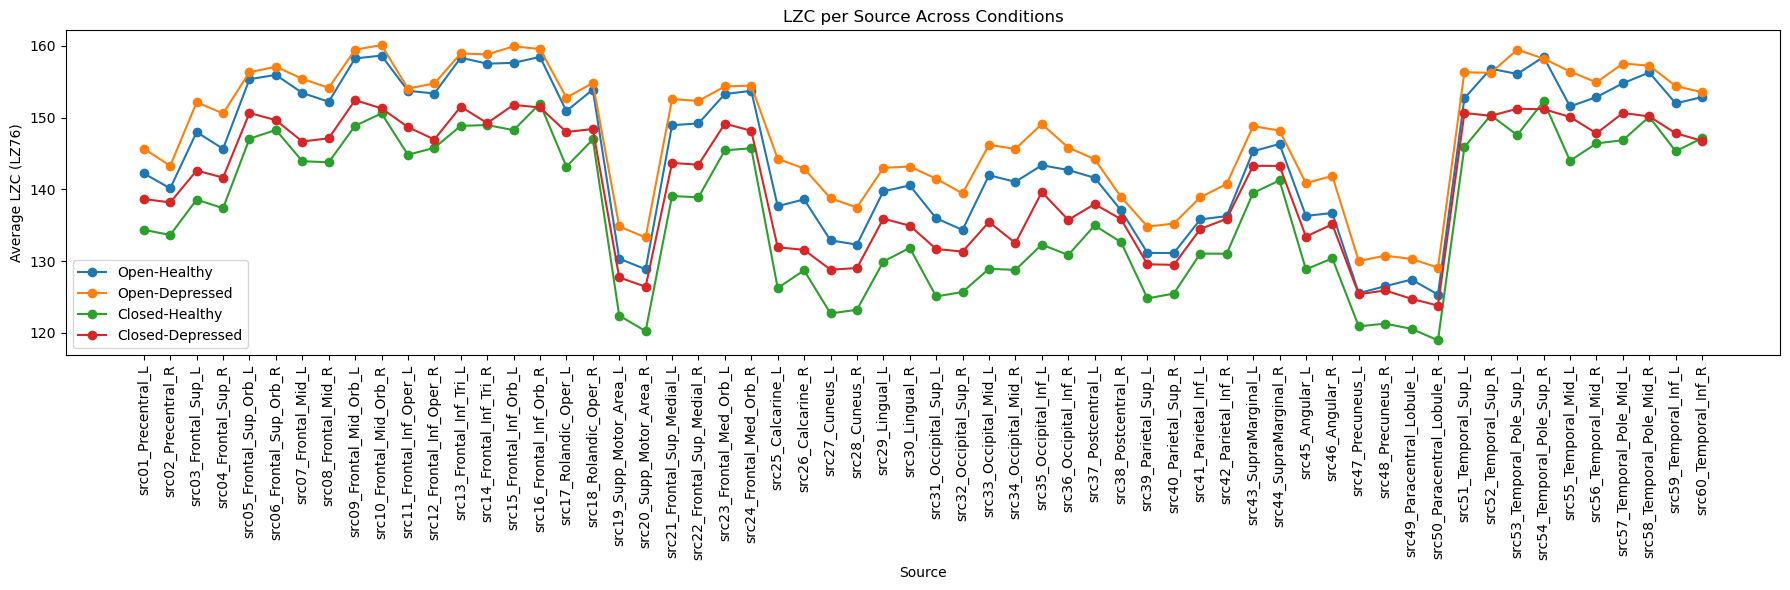

In [14]:
conditions = [
    ('open', 'healthy'),
    ('open', 'depressed'),
    ('closed', 'healthy'),
    ('closed', 'depressed')
]
condition_labels = [
    'Open-Healthy',
    'Open-Depressed',
    'Closed-Healthy',
    'Closed-Depressed'
]
source_indices = np.arange(1, 61)

plt.figure(figsize=(18, 6))
for i, (eyes, health) in enumerate(conditions):
    mask = (
        (lzc_source_df['eyes'] == eyes) &
        (lzc_source_df['health'] == health)
    )
    avg = lzc_source_df.loc[mask, 'lz76_source_avg'].values
    plt.plot(source_indices, avg, marker='o', label=condition_labels[i])

plt.xticks(source_indices, [f'src{idx+1:02d}_{source_names[idx]}' for idx in range(60)], rotation=90)
plt.xlabel('Source')
plt.ylabel('Average LZC (LZ76)')
plt.title('LZC per Source Across Conditions')
plt.legend()
plt.tight_layout()
plt.show()

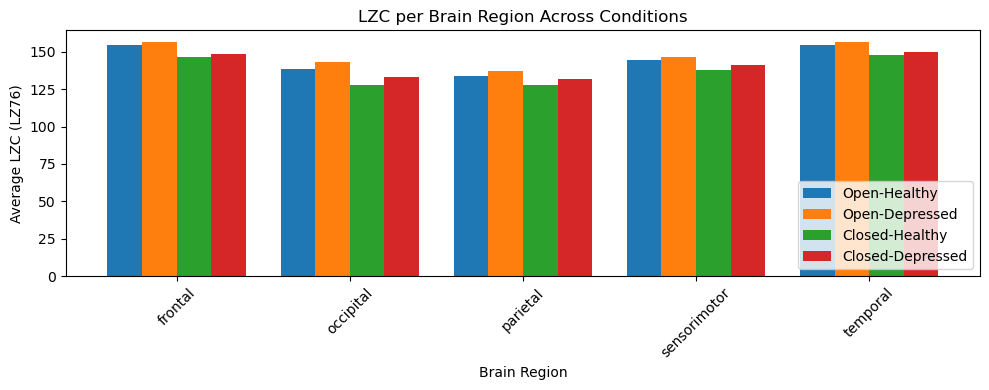

In [ ]:
plt.figure(figsize=(10, 4))
for i, (eyes, health) in enumerate(conditions):
    mask = (
        (lzc_region_df['eyes'] == eyes) &
        (lzc_region_df['health'] == health)
    )
    region_avgs = lzc_region_df.loc[mask, :]
    plt.bar(
        np.arange(len(region_avgs)) + i*0.2,
        region_avgs['lz76_region_avg'],
        width=0.2,
        label=condition_labels[i]
    )

plt.xticks(np.arange(len(region_avgs)) + 0.3, region_avgs['region'], rotation=45)
plt.xlabel('Brain Region')
plt.ylabel('Average LZC (LZ76)')
plt.title('LZC per Brain Region Across Conditions')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# Merge lzc_df with df_raw according to subject index
df_raw['subject_idx'] = pd.to_numeric(df_raw.iloc[:, 0], errors='coerce').astype('Int64')
merged_df = pd.merge(lzc_df, df_raw, on='subject_idx', how='left')
print(merged_df)


                level    eyes     health  subject_idx region  \
0             overall    open    healthy         <NA>    NaN   
1             overall    open  depressed         <NA>    NaN   
2             overall  closed    healthy         <NA>    NaN   
3             overall  closed  depressed         <NA>    NaN   
4             subject    open    healthy          507    NaN   
...               ...     ...        ...          ...    ...   
15967  subject_source  closed  depressed          626    NaN   
15968  subject_source  closed  depressed          626    NaN   
15969  subject_source  closed  depressed          626    NaN   
15970  subject_source  closed  depressed          626    NaN   
15971  subject_source  closed  depressed          626    NaN   

                      source_idx        lz76     id   MDD MDD_note  HamD  sex  \
0                            NaN  145.097647    NaN   NaN      NaN   NaN  NaN   
1                            NaN  148.061891    NaN   NaN      NaN   

In [20]:
import statsmodels.api as sm

merged_df['depressed'] = merged_df.iloc[:, 1].apply(lambda x: 1 if x == 1 else 0)
merged_df['intercept'] = 1

# Perform regression analysis for each combination of eyes, area, and band
variables = ['intercept', 'depressed', 'BDI', 'BDI_Anh', 'BDI_Mel', 'TAI', 'sex', 'age']
rlm_results = pd.DataFrame(columns=['eyes', 'region', 'variable', 'p_value', 't_value', 'p_significant', 't_significant'])

for eyes in ['open', 'closed']:
    for region in merged_df['region'].unique():
        # Run sm.RLM for each subset of the DataFrame
        subset = merged_df[(merged_df['eyes'] == eyes) & (merged_df['region'] == region)]
        if subset.empty:
            continue
        model = sm.RLM(subset['lz76'], subset[variables], missing='drop', M=sm.robust.norms.HuberT())
        results = model.fit()
        # print(results.summary())
        for var in variables[1:]:
            p_significant = results.pvalues[var] <= 0.05
            t_significant = abs(results.tvalues[var]) >= 1.7
            new_permutation = pd.DataFrame([{
                'eyes': eyes,
                'region': region,
                'variable': var,
                'p_value': results.pvalues[var],
                't_value': results.tvalues[var],
                'p_significant': p_significant,
                't_significant': t_significant
            }])
            rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)

print(rlm_results)

C:\Users\lukad\AppData\Local\Temp\ipykernel_42516\2216924299.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)


      eyes    region   variable   p_value   t_value p_significant  \
0     open   frontal  depressed  0.000002  4.716933          True   
1     open   frontal        BDI  0.045411  2.000831          True   
2     open   frontal    BDI_Anh  0.923035 -0.096612         False   
3     open   frontal    BDI_Mel  0.529372 -0.628965         False   
4     open   frontal        TAI  0.036169 -2.095018          True   
..     ...       ...        ...       ...       ...           ...   
65  closed  temporal    BDI_Anh  0.157365  1.413990         False   
66  closed  temporal    BDI_Mel  0.026142 -2.224091          True   
67  closed  temporal        TAI  0.059218 -1.886574         False   
68  closed  temporal        sex  0.152487 -1.430801         False   
69  closed  temporal        age  0.845667  0.194650         False   

   t_significant  
0           True  
1           True  
2          False  
3          False  
4           True  
..           ...  
65         False  
66          True  


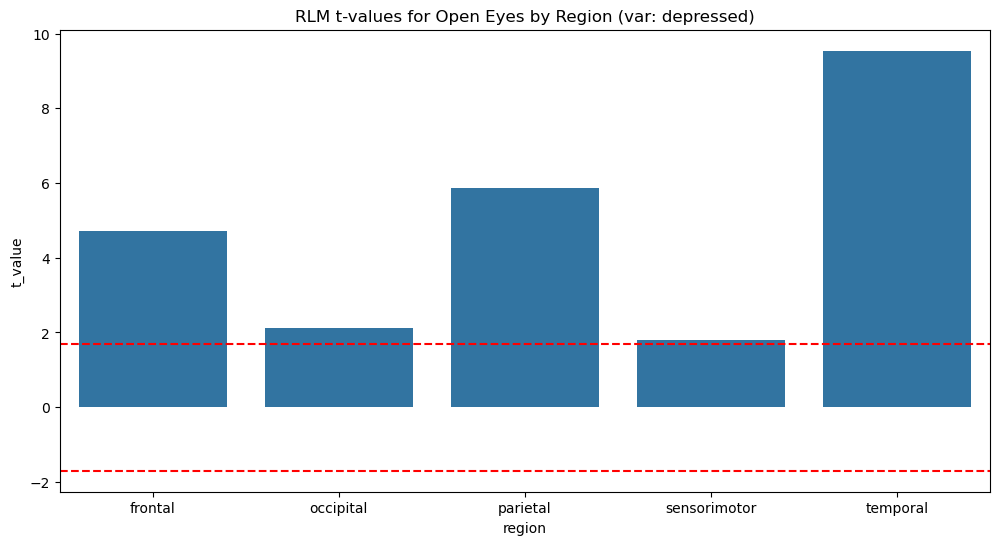

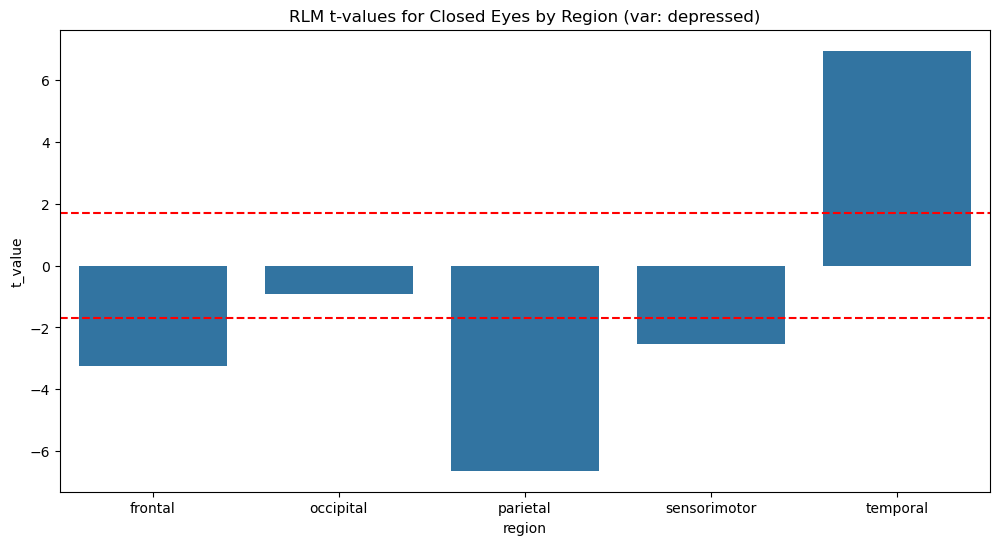

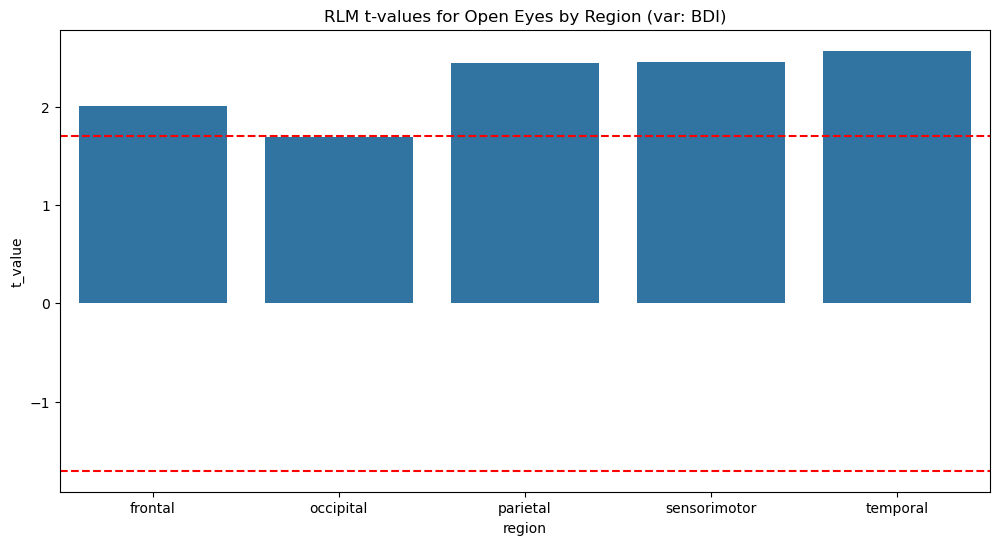

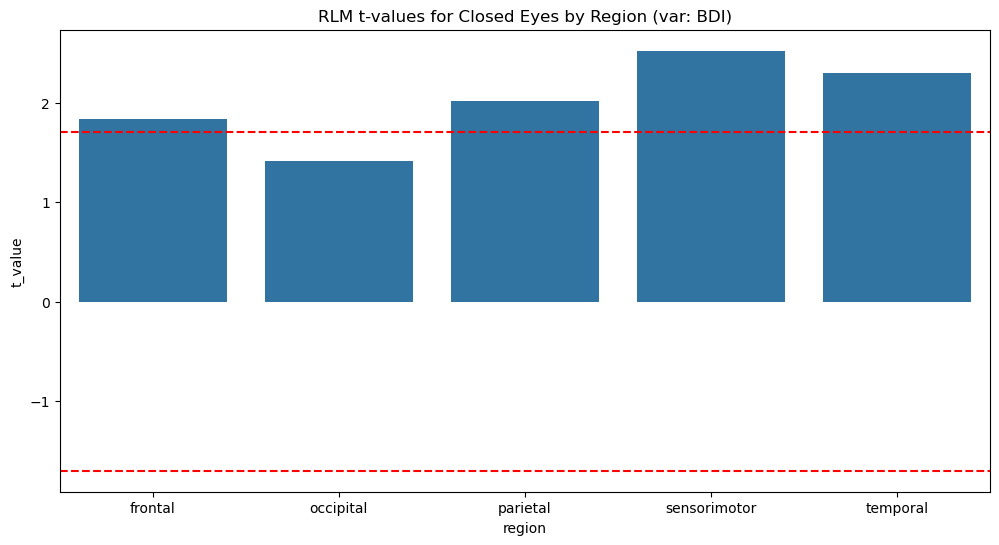

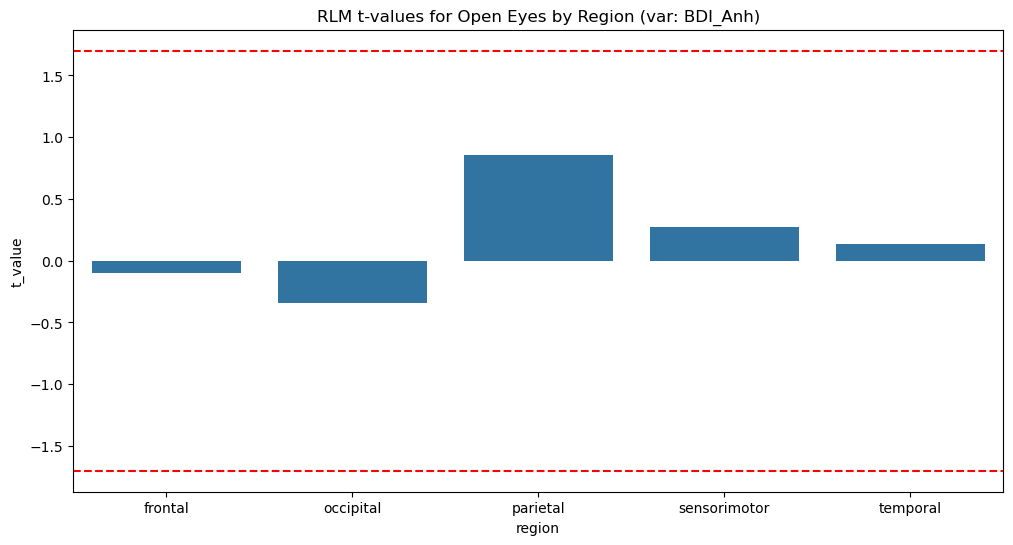

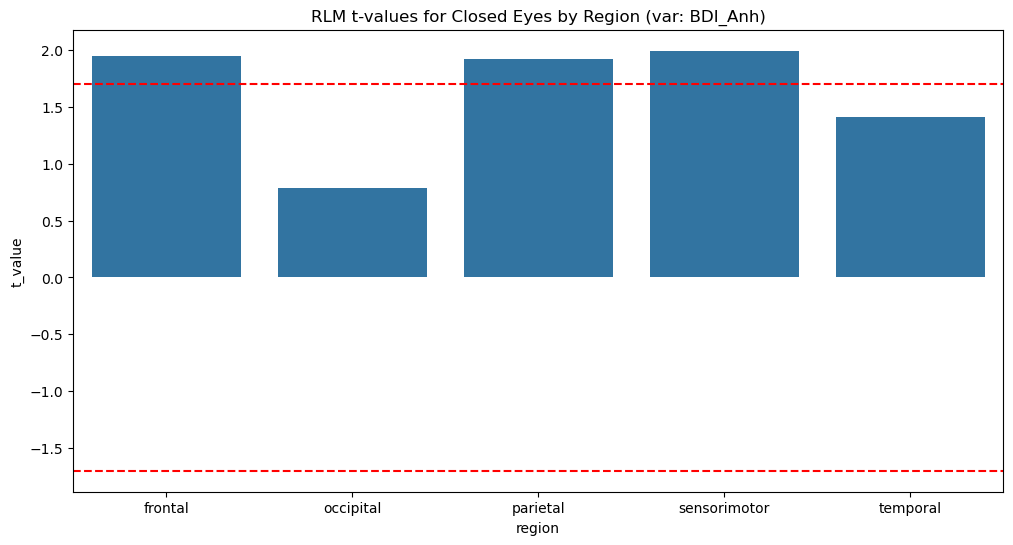

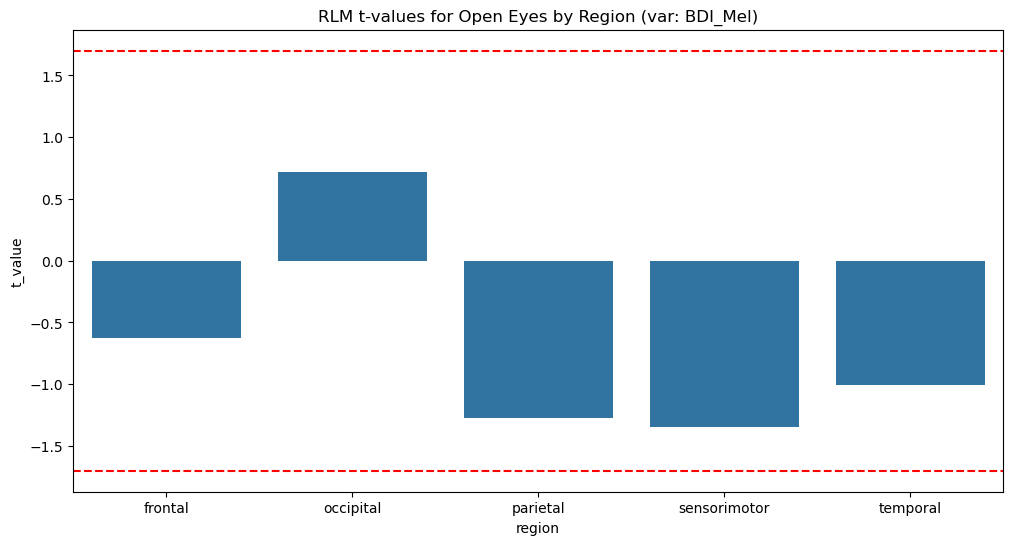

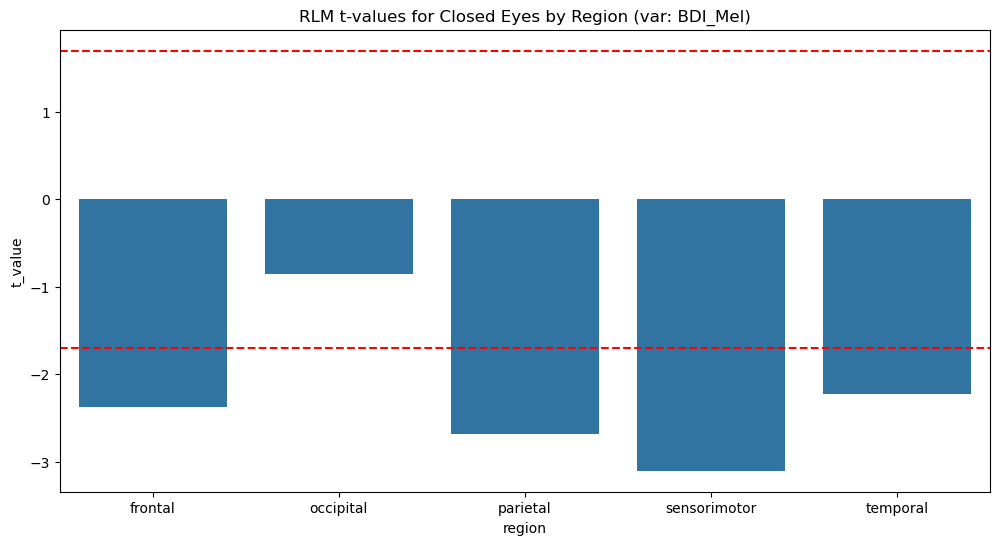

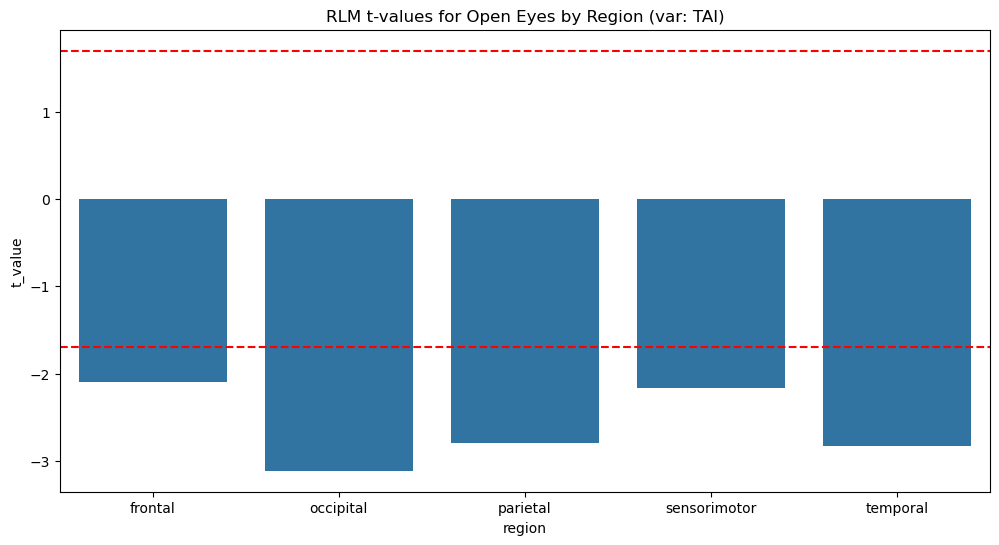

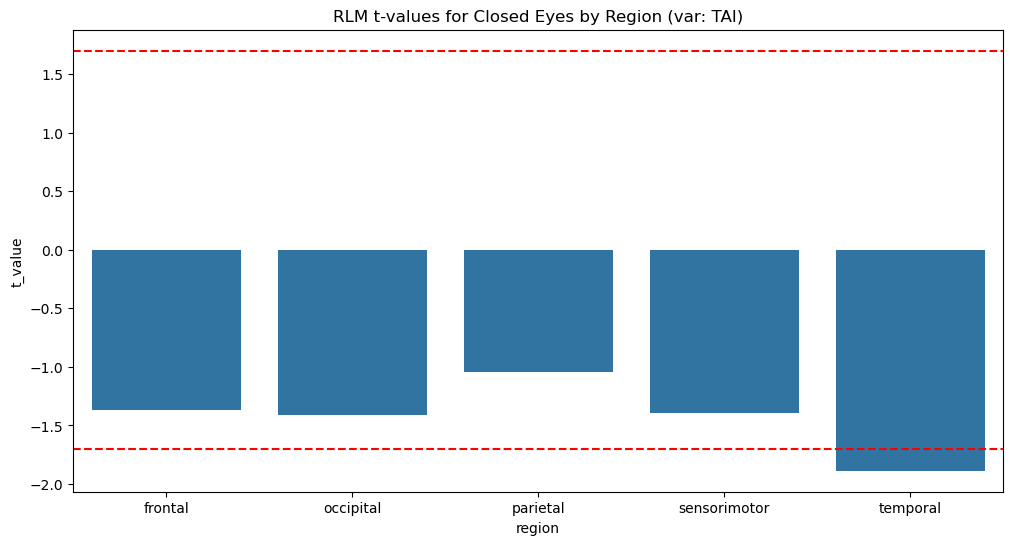

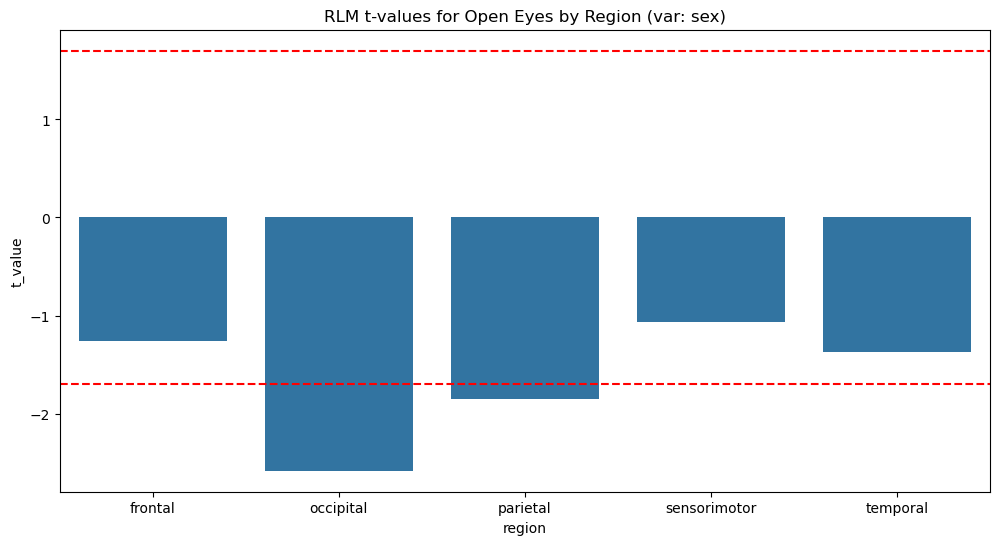

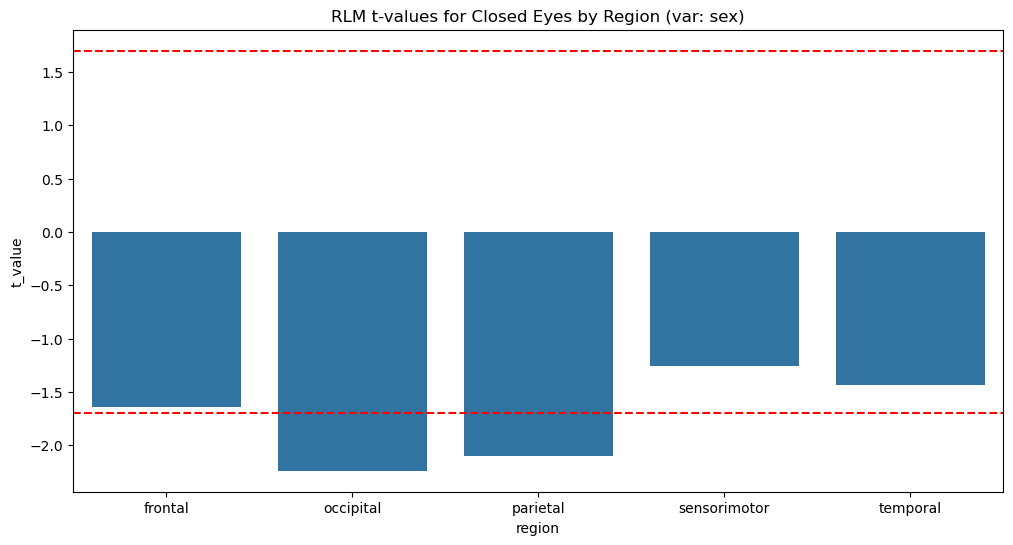

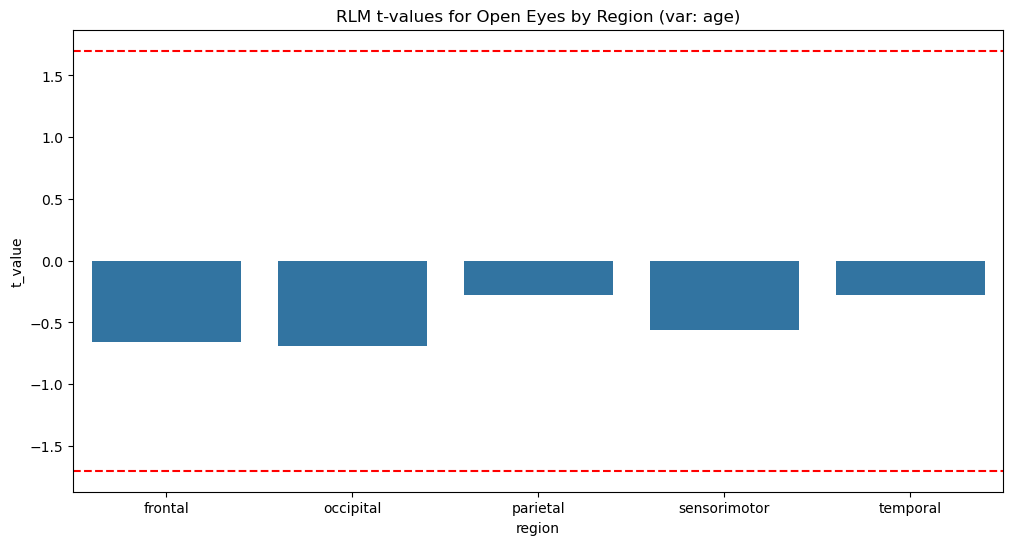

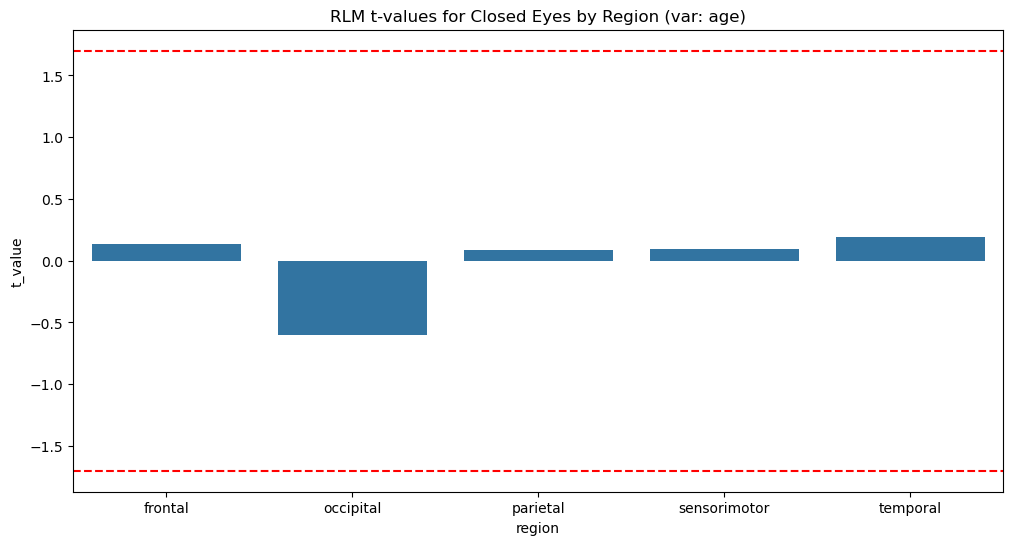

In [22]:
import seaborn as sns

def barplot_significance(eyes, var):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=rlm_results[(rlm_results['eyes'] == eyes) & (rlm_results['variable'] == var) & (rlm_results['region'].isin(region_map.keys()))],
                x='region', y='t_value', errorbar=None)
    plt.title(f'RLM t-values for {str.capitalize(eyes)} Eyes by Region (var: {var})')
    plt.axhline(y=1.7, color='r', linestyle='--')
    plt.axhline(y=-1.7, color='r', linestyle='--')
    plt.show()

for var in variables:
    if var in ['intercept', 'age_squared']:
        continue
    barplot_significance('open', var)
    barplot_significance('closed', var)